In [1]:
%matplotlib notebook

import numpy as np
# import tensorflow as tf
import scipy.io
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import clear_output, display
from scipy.ndimage import gaussian_filter
from scipy.spatial import distance
from sklearn.cluster import KMeans
import multiprocessing
from functools import partial
import time

import wolff
import wolff_cross

# Track calculation errors
np.seterr('raise')

# tf.debugging.set_log_device_placement(False)

{'divide': 'raise', 'over': 'raise', 'under': 'raise', 'invalid': 'raise'}

In [2]:
# Testing code
wolff_cross.cross_decode(
    np.random.normal(10, 1, size=(100, 17, 100)), 
    np.random.normal(0, np.pi, size=(100)), 
    np.pi / 6,
    device_i=2)

Preparing sigma...
Done with sigma.
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]
Trial 1/100
Trial 2/100
Trial 3/100
Trial 4/100
Trial 5/100
Trial 6/100
Trial 7/100
Trial 8/100
Trial 9/100
Trial 10/100
Trial 11/100
Trial 12/100
Trial 13/100
Trial 14/100
Trial 15/100
Trial 16/100
Trial 17/100
Trial 18/100
Trial 19/100
Trial 20/100
Trial 21/100
Trial 22/100
Trial 23/100
Trial 24/100
Trial 25/100
Trial 26/100
Trial 27/100
Trial 28/100
Trial 29/100
Trial 30/100
Trial 31/100
Trial 32/100
Trial 33/100
Trial 34/100
Trial 35/100
Trial 36/100
Trial 37/100
Trial 38/100
Trial 39/100
Trial 40/100
Trial 41/100
Trial 42/100
Trial 43/100
Trial 44/100
Trial 45/100
Trial 46/100
Trial 47/100
Trial 48/100
Trial 49/100
Trial 50/100
Trial 51/100
Trial 52/100
Trial 53/100
Trial 54/100
Trial 55/100
Trial 56/100
Trial 57/100
Trial 58/100
Trial 59/100
Trial 60/100
Trial 61/100
Trial 62/100
Trial 63/100
Trial 64/100
Trial 65/100
Trial 66/100
Trial 67/100
Trial 68/100
Trial 69/100
Trial 70/100
Trial 

array([[[ 0.05855294, -0.01687563, -0.08483055, ..., -0.0386661 ,
          0.05671661,  0.013157  ],
        [-0.05206102, -0.06243266,  0.18502706, ..., -0.0344909 ,
         -0.0566923 , -0.07065383],
        [ 0.12973132, -0.02042569,  0.00090232, ..., -0.02543793,
         -0.04910052, -0.02251085],
        ...,
        [-0.10088839, -0.03956178,  0.01540042, ..., -0.0126418 ,
         -0.03495917,  0.06414479],
        [-0.044016  ,  0.10133408, -0.08579633, ...,  0.06997677,
         -0.01971046,  0.03698965],
        [ 0.02161843, -0.06747564, -0.05933856, ..., -0.08073406,
         -0.00400848,  0.04333912]],

       [[-0.11365008,  0.02812325,  0.04634273, ...,  0.04060311,
         -0.00407017, -0.00165954],
        [ 0.10615787, -0.03645324,  0.09653636, ...,  0.07220939,
          0.00115901,  0.0159011 ],
        [-0.13158685,  0.01958054, -0.03189023, ...,  0.06250071,
          0.05215264, -0.00055593],
        ...,
        [ 0.12890773, -0.04000106, -0.07209814, ..., -

In [18]:
# path = '/Users/share/Chiel4Loran/exp2/sim3/'
path = '/Users/share/Chiel4Loran/Decoding/exp2/'
# mem1_file = 'neuro_mem2_1.npy'
mem1_file = 'subj_1_mem_neuron_data_first_0.npy'
mem2_file = 'neuro_mem2_2.npy'
# angles_file = 'initial_angles2.npy'
angles_file = 'subj_1_initial_angles_0.npy'

In [19]:
mem_data1 = np.load(path + mem1_file) # trials by timesteps by neurons

<IPython.core.display.Javascript object>


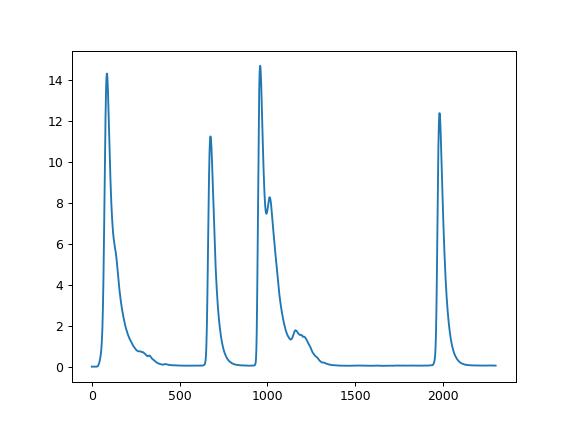

In [21]:
meaned = np.mean(np.mean(mem_data1, 0), 1)
plt.plot(meaned)

In [5]:
mem_data2 = np.load(path + mem2_file)

In [23]:
angles = np.load(path + angles_file)
# Convert to radians
angles = angles / 360 * 2 * np.pi

In [24]:
# 'Scale' angles
angles = angles * 2

In [25]:
def group(mem_data):
    cut_data = mem_data[:, :500, :] # trials by 500 by neurons
    num_channels = 17
    neurons = np.mean(cut_data, 1).T # neurons by trials
    kmeans = KMeans(n_clusters=num_channels, n_init=20, n_jobs=10, tol=1e-20).fit(neurons)
    
    data = np.empty((mem_data.shape[0], num_channels, mem_data.shape[1])) # trials by num_channels by timesteps
    for channel in range(num_channels):
        clear_output(wait=True)
        print(str(channel + 1) + "/" + str(num_channels))
        data[:, channel, :] = np.mean(mem_data[:, :, kmeans.labels_ == channel], axis=2)
        
    return data

In [26]:
data1 = group(mem_data1)

17/17


In [10]:
data2 = group(mem_data2)

17/17


In [27]:
# Add noise to prevent division by zero errors in covdiag()
data1 += np.random.normal(scale=0.5, size=data1.shape)
# data2 += np.random.normal(scale=0.5, size=data2.shape)

In [28]:
# Decode up to this timepoint
decode_up_to = 600
data1 = data1[:, :, :decode_up_to]
# data2 = data2[:, :, :decode_up_to]

In [29]:
bin_width = np.pi / 6
# bin_width = np.pi / 3
angspace = np.arange(np.pi, np.pi, bin_width)

In [35]:
data1 = np.load('/Users/s3182541/STSP/Decoding/data/final/exp1/1/data1.npy')[:360]
angles = np.load('/Users/s3182541/STSP/Decoding/data/final/exp1/1/angles.npy')[:360]

In [30]:
device_i = 1
instances = 1

if __name__ == '__main__':
    print("Decoding primary...")
    start_t = time.time()
    cross_cos_amp1 = wolff_cross.cross_decode(data1, 
                                              angles, 
                                              bin_width, 
                                              device_i=device_i)
    end_t = time.time()
    print(end_t - start_t)
#     print("Decoding secondary...")
#     cross_cos_amp2 = wolff_cross.cross_decode(data2, 
#                                               angles, 
#                                               bin_width, 
#                                               device_i=device_i, 
#                                               instances=instances)

Decoding primary...
Preparing sigma...
Done with sigma.
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]
Trial 1/288
Trial 2/288
Trial 3/288
Trial 4/288
Trial 5/288
Trial 6/288
Trial 7/288
Trial 8/288
Trial 9/288
Trial 10/288
Trial 11/288
Trial 12/288
Trial 13/288
Trial 14/288
Trial 15/288
Trial 16/288
Trial 17/288
Trial 18/288
Trial 19/288
Trial 20/288
Trial 21/288
Trial 22/288
Trial 23/288
Trial 24/288
Trial 25/288
Trial 26/288
Trial 27/288
Trial 28/288
Trial 29/288
Trial 30/288
Trial 31/288
Trial 32/288
Trial 33/288
Trial 34/288
Trial 35/288
Trial 36/288
Trial 37/288
Trial 38/288
Trial 39/288
Trial 40/288
Trial 41/288
Trial 42/288
Trial 43/288
Trial 44/288
Trial 45/288
Trial 46/288
Trial 47/288
Trial 48/288
Trial 49/288
Trial 50/288
Trial 51/288
Trial 52/288
Trial 53/288
Trial 54/288
Trial 55/288
Trial 56/288
Trial 57/288
Trial 58/288
Trial 59/288
Trial 60/288
Trial 61/288
Trial 62/288
Trial 63/288
Trial 64/288
Trial 65/288
Trial 66/288
Trial 67/288
Trial 68/288
Trial 69/288

In [31]:
c = np.mean(cross_cos_amp1, 0)

In [37]:
plt.close()
plt.imshow(gaussian_filter((c+c.T)/2, sigma=8), origin='lower', cmap='magma')

<IPython.core.display.Javascript object>

In [7]:
1995/60

33.25

In [29]:
c1 = np.mean(cross_cos_amp1, 0)
c_transformed1 = (c1 + c1.T) / 2

c2 = np.mean(cross_cos_amp2, 0)
c_transformed2 = (c2 + c2.T) / 2

In [60]:
c_transformed1 = np.load('c_transformed1.npy')
c_transformed2 = np.load('c_transformed2.npy')

In [53]:
limit = 600

c_transformed1 = c_transformed1[:limit, :limit]
c_transformed2 = c_transformed2[:limit, :limit]

In [61]:
filtered1 = gaussian_filter(c_transformed1, sigma=8)
filtered2 = gaussian_filter(c_transformed2, sigma=8)

In [13]:
# Matlab-shared Nengo data
# scipy.io.savemat('wolff/nengo_mem.mat', dict(data=data, angles=angles, bin_width=bin_width, angspace=angspace))

In [62]:
vmin = min(np.min(filtered1), np.min(filtered2))
vmax = max(np.max(filtered1), np.max(filtered2))

<IPython.core.display.Javascript object>


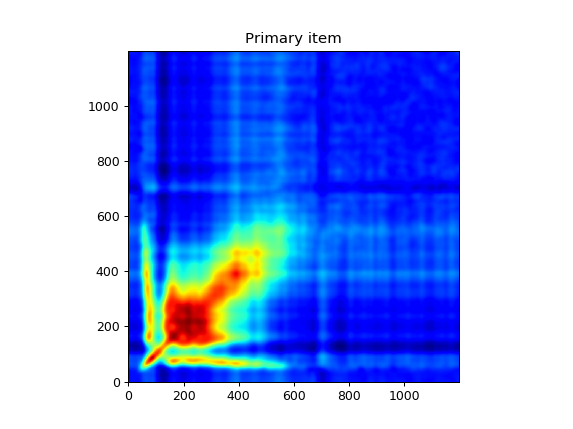

In [65]:
plt.close()

plt.title('Primary item')
# plt.imshow(filtered1, cmap='jet', origin='lower', vmin=vmin, vmax=vmax)
plt.imshow(filtered1, cmap='jet', origin='lower')

<IPython.core.display.Javascript object>


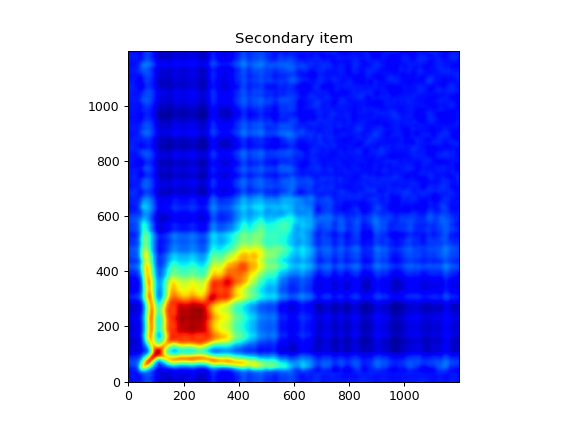

In [64]:
plt.close()

plt.title('Secondary item')
plt.imshow(filtered2, cmap='jet', origin='lower', vmin=vmin, vmax=vmax)